In [1]:
import covid19sim
import pandas as pd
import numpy as np
import dill
from collections import defaultdict
import datetime
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filename = "../src/covid19sim/logs2/tracker_data_n_100_seed_0_20200506-172227.pkl"

In [3]:
data = dill.load(open(filename,"rb"))

In [4]:
humans = {}
for i in data['human_monitor'].keys():
    row = defaultdict(list)
    for c,j in enumerate(data['human_monitor'][i]):
        for k in j.keys():
            row[k].append(j[k])

    # index = (timestamp, attr)
    for k in row.keys():
        humans[(i,k)] = row[k]
    
humans = pd.DataFrame.from_dict(humans, orient="index")
humans.index = pd.MultiIndex.from_tuples(humans.index)

### Select chain of infections to track
Use `data['infection_monitor']` to select the chain of infections. If A infected B, B infected C. Note their numbers.

In [5]:
infection_chain = data['infection_monitor']
infector_infectee_update_messages = data['infector_infectee_update_messages']

In [6]:
def _color_cell(val):
    try:
        val = int(val.split()[0].split(":")[-1])
    except:
        import pdb; pdb.set_trace()
    
    color = "white"
    if val == 0:
        color = "#b3e8a6"#"green"
    elif val == 1:
        color = "#ffde22" #"yellow"
    elif val == 2:
        color = "#ff8928" #"orange"
    elif val == 3:
        color = "#f0aea3" # "red"
    else:
        raise
    return f"background-color: {color}"


def _color_cell_raw(val):
    color = "white"
    if val == "positive":
        color = "red"
    return f"background-color: {color}"

# format the content of a cell
def summarize(x):
    risk_levels = x.xs('risk_level', level=1)
    rec_levels = x.xs('rec_level', level=1)
    test_results = x.xs('test_result', level=1)
    n_symptoms = x.xs('n_symptoms', level=1)
    infection_timestamp = x.xs('infection_timestamp', level=1)
    risks = x.xs('risk', level=1)
    
    columns = risk_levels.columns
    y = pd.DataFrame(columns=columns, index=x.index.unique(level=0))
    
    today = x.index.unique(level=0).item().date()
    max_risk_level = -1
    for idx in range(len(columns)):
        infector_column = columns[idx] # infector
        RL = risk_levels[infector_column].item()
        Rec = rec_levels[infector_column].item()
        test = test_results[infector_column].item()
        symptoms = n_symptoms[infector_column].item()
        
        cell = f"Rec:{Rec} R:{RL}"
    
        if max_risk_level>=0:
            # use the carried message here
            cell += f" M:{max_risk_level}"

        if test == "positive":
            cell += f"  Test:+"
        elif test == "negative":
            cell += "  Test:-"
        
        if symptoms > 0:
            cell += f"  S:{symptoms}"
        
        # arrows
        if idx+1 < len(columns):
            infectee_column = columns[idx+1]
            next_infection_timestamp = infection_timestamp[infectee_column].item()

            if next_infection_timestamp is not None:
                # infection arrow
                if next_infection_timestamp.date() == today:
                    cell += ' \u2623 \u2623 \u2623 \u2623' # \u21e8 hollow arrow ; \u2b95 for solid arrow
        
                # update messages arrow
                infector_name = f"human:{infector_column+1}"
                infectee_name = f"human:{infectee_column+1}"
                messages = infector_infectee_update_messages[infector_name][infectee_name]
                max_risk_level = -1
                for timestamp, risk_l in messages.items():
                    if timestamp.date() == today:
                        cell += ' \u2709'
                        max_risk_level = max(max_risk_level, risk_l)
                
                # content of the message (can be more than one in a single day)
                # carry max_risk_level for the next person in the chain
                # no need to do anything here
        
        
        y[infector_column] = cell
    
    y.reset_index(drop=True, inplace=True)
    return y
    
def spy(id1, id2, id3):
    pd.set_option('display.max_rows', None)
    df = humans.loc[(slice(None), ("infection_timestamp","risk", "test_result", "n_symptoms", "risk_level", "rec_level")), [id1-1,id2-1,id3-1]]
    df = df.style.applymap(_color_cell_raw)
    return df

def spy_pro(ids):
    ids = [x-1 for x in ids]
    df = humans.loc[(slice(None), ("infection_timestamp", "risk", "test_result", "n_symptoms", "risk_level", "rec_level")), ids]

    # display until here
    notnull = pd.notnull(df[ids[-1]].unstack().infection_timestamp)
    last_index = notnull[::-1].idxmax() + datetime.timedelta(days=2)

    df = df.groupby(level=0, axis=0).apply(lambda x: summarize(x))
    df.reset_index(level=1, drop=True, inplace=True)
    df.index = df.index.date
    df = df[df.index <= last_index]

    df.columns = [f"human:{x+1}" for x in df.columns]
    df = df.style.applymap(_color_cell).set_properties(**{"font-weight":600, "font-size": "150%", 'border-color': 'black', 'text-align': 'left', 'border': '2px solid #4f2121'})

    def remove_rec(x):
        return " ".join(x.split()[1:])

    df.format(remove_rec)

    # bells and whistles
    def hover(hover_color="#ffff99"):
        return dict(selector="tr:hover",
                    props=[("background-color", "%s" % hover_color)])

    styles = [
        hover(),
        dict(selector="th", props=[("font-size", "150%"),
                                   ("text-align", "center")]),
        dict(selector="caption", props=[("caption-side", "bottom"), ("font-size", "150%"), ("font-weight", 600)])
    ]

    df = df.set_table_styles(styles).set_caption("Risk Propagation among individuals in a chain")
    return df

In [7]:
# get chains
import random

def get_random_chain(infection_chain):
    start = random.choice(range(len(infection_chain)))

    infector_chain = []
    infector_chain.append(infection_chain[start][0])
    infectee = infection_chain[start][1]
    for idx in range(start+1, len(infection_chain)):
        if infection_chain[idx][0] == infectee:
            infector_chain.append(infectee)
            infectee = infection_chain[idx][1]

    if len(infector_chain) == 1:
        return get_random_chain(infection_chain)
    
    return [int(x.split(":")[-1]) for x in infector_chain]
         

In [9]:
from IPython.display import HTML
ids = get_random_chain(infection_chain)
spy_pro(ids)

,human:61,human:59,human:8
2020-02-28,R:0,R:0,R:0
2020-02-29,R:0,R:0,R:0
2020-03-01,R:0,R:0,R:0
2020-03-02,R:0,R:0,R:0
2020-03-03,R:0,R:0,R:0
2020-03-04,R:0,R:0,R:0
2020-03-05,R:0,R:0,R:0
2020-03-06,R:0,R:0,R:0
2020-03-07,R:0,R:0,R:0
2020-03-08,R:0,R:0,R:0


### plot risk trajectory of people until they are deemed positive
once someone is positive, the risk only goes to 1.0 and then 0.0 when it recovers

In [50]:
def plot_risk_trajectory(ids):
    def direction():
        x = random.random() < 0.5 
        return 2 * x - 1
    
    ids = [x-1 for x in ids]
    colormap = ['red', 'orange', 'blue', 'green', 'gray', 'purple']
    # risk scores
    df = humans.loc[(slice(None), ("risk")), ids]
    # df.replace(0, np.nan, inplace=True)
    df = df.unstack().reset_index(drop=True)
    df.columns = df.columns.droplevel(level=1)

    # infection time
    df_i = humans.loc[(slice(None), ("infection_timestamp")), ids]
    df_i.index = df_i.index.droplevel(level=1)
    df_i = df_i.reset_index(drop=True)

    idx = 0
    annotations = []
    for id in ids[1:]:
        x = [x for x in df_i[id].unique() if x][0]
        infection_day = df_i[id][df_i[id] == x].index[0]
        infector = ids[idx]
        infection_risk = df[infector][infection_day]
        infectee = id
        annotations.append([infection_day, infection_risk, f"{infector+1} -> {infectee+1}", colormap[idx+1]])    
        idx += 1

    df.columns = [f"human:{x+1}" for x in df.columns]
    ax = df.plot(figsize=(15,10), color=colormap)
    for x in annotations:
        if x[2]:
            ax.annotate(f"{str(x[2])}", xy=(x[0], x[1]), xytext=(x[0] + 2*direction(), x[1]+ 0.05*direction()), size=15, color=x[3], arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))

    ax.set_title("Risk Trajectory & Risk @ Contagion", size=25)
    ax.grid(b=True, axis='x', alpha=0.6, which="major")
    ax.minorticks_on()
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black', axis='x', alpha=0.3)
    ax.grid(True, axis='y', alpha=0.3)

    ax.legend(prop={"size":20}, loc="upper left")
    ax.tick_params(labelsize=25)
    plt.xlabel("Days since outbreak", fontsize=30)
    plt.ylabel("Risk", fontsize=30)
    fig = ax.get_figure()

    return fig

In [39]:
ids = get_random_chain(infection_chain)

/network/home/guptapra/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


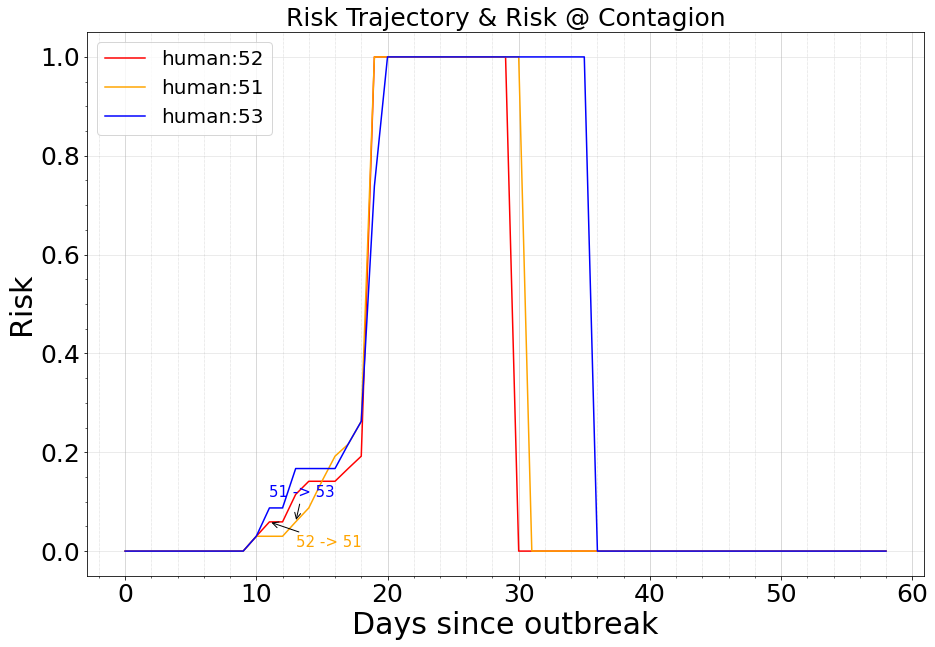

In [51]:
plot_risk_trajectory(ids)